# Exploratory data analysis  
## Dataset: English Wikipedia clickstream for December 2018

In [1]:
import re

import requests

# import html parsers before BeautifulSoup
import lxml

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import networkx as nx

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import powerlaw

In [2]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

#### Read in the data

In [4]:
# Read the cleaned up EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12_clean.tsv"
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])

In [5]:
# Replace the false missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [6]:
df.head()

,prev,curr,type,n
0,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
1,other-search,ForeverAtLast,external,40
2,other-empty,ForeverAtLast,external,85
3,First_Families_of_Pakistan,Jehangir_Wadia,link,19
4,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36


In [7]:
df.describe(include='all')

,prev,curr,type,n
count,29847736,29847736,29847736,29847736.00
unique,1714260,5183771,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5093433,127578,17851574,nan
mean,NaN,NaN,NaN,230.46
std,NaN,NaN,NaN,90303.30
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,28.00
75%,NaN,NaN,NaN,71.00


In [10]:
df.sort_values("n", ascending=False, inplace=True)

In [25]:
edge_traffic_frequencies = df.n.value_counts()

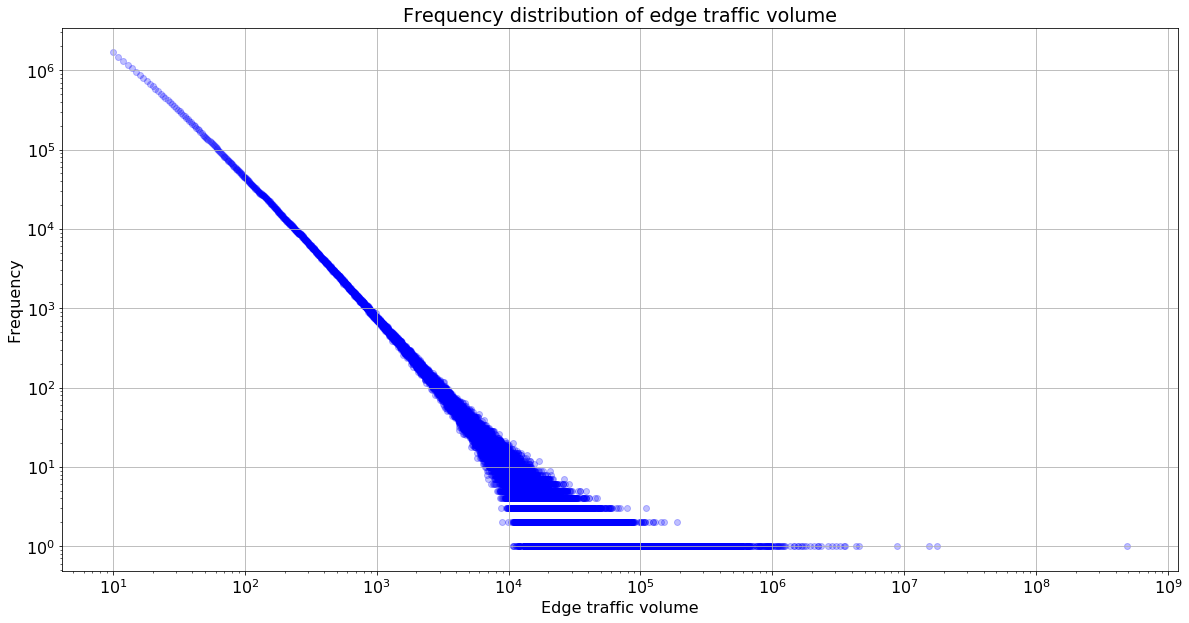

In [48]:
my_alpha = 0.25
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of edge traffic volume");

The clickstream dataset is a collection of referer-requested webpage pairs (edges) with aggregated traffic count for the pair within the given month. These edges are of 3 types in the data: **external**, **link** and **other**. The external type means that the referer webpage is some webpage outside of the English Wikipedia.  

The exact **external** referer webpages are not specified in the data, and are instead aggregated into 5 categories (as decribed [here](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Data_Preparation)):  
- **other-external**: External website referers, i.e. the user went from some external website to a Wikipedia article page.  
- **other-search**: External search referers, i.e. the user searched for something on a search engine page and from there went to a Wikipedia article page.
- **other-internal**: Referers from some other Wikimedia project. It could be a different language Wikipedia or some other Wikimedia project that is not a Wikipedia.
- **other-empty**: An empty referer. This can be the result of a browser homepage setting, a security measure, a bot, etc.
- **other-other**: Any other external referer.  

The **link** and **other** reference types are both for edges connecting Wikipedia articles. The **link** type means that the user followed a link from one Wikipedia article to another. And the **other** type means that the user went from one Wikipedia article to another, but there was no link between them. This happens if the user gets to the second article by searching from the first article, or if the referer is spoofed.

Here's the distribution of traffic volume and edge counts across the 3 reference types.

In [11]:
edges_count = df.groupby("type").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = df.groupby("type").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)

summary_by_type = pd.concat([edges_count, traffic_volume], axis=1)
summary_by_type["edges_count_pct"] = summary_by_type["edges_count"] / summary_by_type["edges_count"].sum()
summary_by_type["traffic_volume_pct"] = summary_by_type["traffic_volume"] / summary_by_type["traffic_volume"].sum()

summary_by_type

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
type,,,,
external,10990982,5100299091,0.37,0.74
link,17851574,1718399222,0.60,0.25
other,1005180,60022438,0.03,0.01


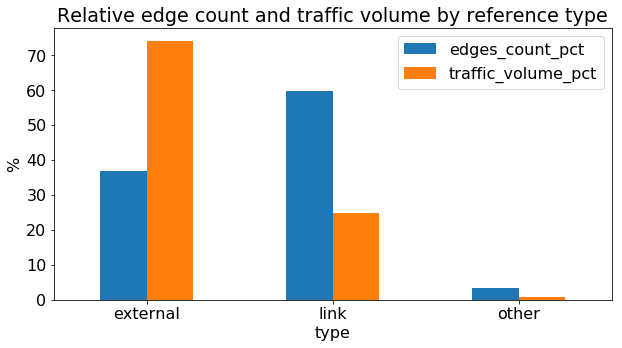

In [12]:
ax = plt.gca()
(summary_by_type[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_type.index)), summary_by_type.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by reference type")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(10,5);

In [16]:
external_edges = df[df.type == 'external']
link_edges = df[df.type == 'link']
other_edges = df[df.type == 'other']

### External reference type

In [17]:
external_edges.describe(include='all')

,prev,curr,type,n
count,10990982,10990982,10990982,10990982.00
unique,5,5163109,1,nan
top,other-empty,Richard_Boone,external,nan
freq,5093433,5,10990982,nan
mean,NaN,NaN,NaN,464.04
std,NaN,NaN,NaN,148805.73
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,38.00
75%,NaN,NaN,NaN,121.00


In [22]:
external_edges.head(10)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21252458,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23951757,other-search,Jason_Momoa,external,3538068
18403529,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


In [30]:
external_edges_traffic_frequencies = external_edges.n.value_counts()

### Link reference type

In [18]:
link_edges.describe(include='all')

,prev,curr,type,n
count,17851574,17851574,17851574,17851574.00
unique,1703705,2598302,1,nan
top,New_York_City,United_States,link,nan
freq,2224,6368,17851574,nan
mean,NaN,NaN,NaN,96.26
std,NaN,NaN,NaN,870.84
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,25.00
75%,NaN,NaN,NaN,56.00


In [23]:
link_edges.head(10)

,prev,curr,type,n
9722110,Jason_Momoa,Lisa_Bonet,link,1166522
6473638,Priyanka_Chopra,Nick_Jonas,link,596798
1830750,Bird_Box,Bird_Box_(film),link,508241
4776073,Nick_Jonas,Priyanka_Chopra,link,493898
23721511,George_H._W._Bush,George_W._Bush,link,453809
6531433,George_H._W._Bush,Pauline_Robinson_Bush,link,419132
18515291,George_H._W._Bush,Barbara_Bush,link,412565
21252092,George_W._Bush,George_H._W._Bush,link,393452
10588026,George_H._W._Bush,Dorothy_Bush_Koch,link,377785
365460,Emily_Atack,Kate_Robbins,link,354577


In [29]:
link_edges_traffic_frequencies = link_edges.n.value_counts()

### Other reference type

In [19]:
other_edges.describe(include='all')

,prev,curr,type,n
count,1005180,1005180,1005180,1005180.00
unique,302292,414847,1,nan
top,Main_Page,Hyphen-minus,other,nan
freq,257794,127458,1005180,nan
mean,NaN,NaN,NaN,59.71
std,NaN,NaN,NaN,3080.46
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,12.00
50%,NaN,NaN,NaN,18.00
75%,NaN,NaN,NaN,35.00


In [24]:
other_edges.head(10)

,prev,curr,type,n
727986,Main_Page,Hyphen-minus,other,2838090
1395264,Main_Page,Lists_of_deaths_by_year,other,1065668
21252593,Main_Page,George_H._W._Bush,other,220667
15997541,Main_Page,Yellow_vests_movement,other,178234
21175288,Main_Page,Balangiga_bells,other,171702
6426095,Main_Page,Pineapple,other,170129
23370493,Main_Page,2018_Sunda_Strait_tsunami,other,100842
28097656,Main_Page,2018_Strasbourg_attack,other,98728
5564468,Main_Page,Voyager_2,other,83172
12932182,Main_Page,OSIRIS-REx,other,78426


In [25]:
other_edges_traffic_frequencies = other_edges.n.value_counts()

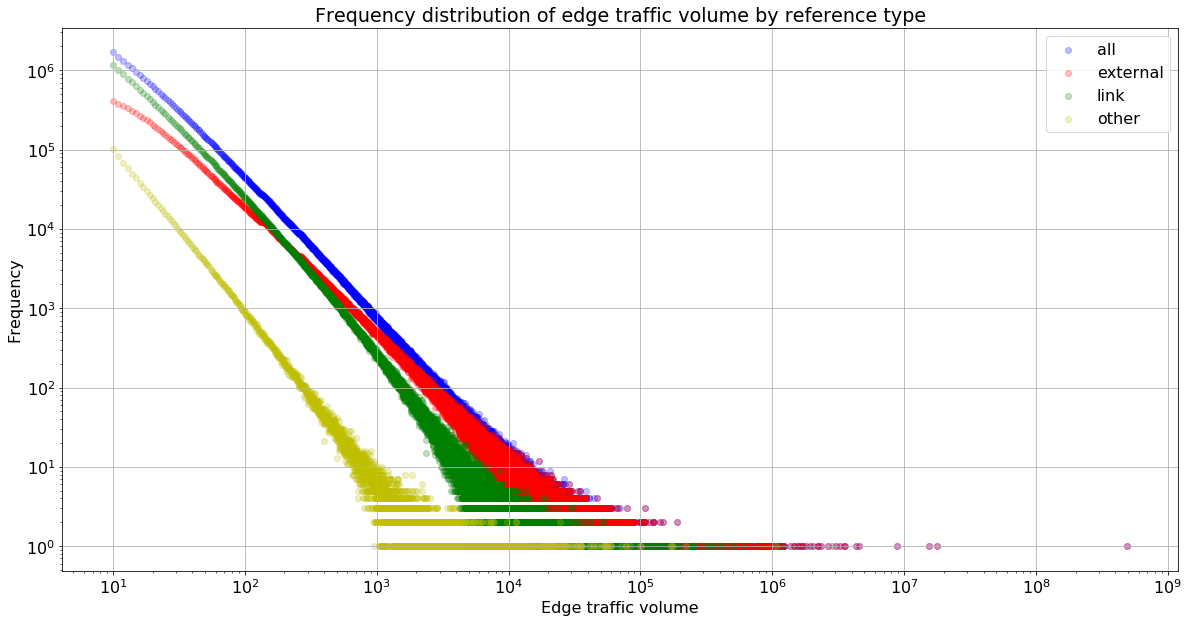

In [47]:
my_alpha = 0.25
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values, \
            c="b", label="all", alpha=my_alpha)
plt.scatter(external_edges_traffic_frequencies.index.values, external_edges_traffic_frequencies.values, \
            c="r", label="external", alpha=my_alpha)
plt.scatter(link_edges_traffic_frequencies.index.values, link_edges_traffic_frequencies.values, \
            c="g", label="link", alpha=my_alpha)
plt.scatter(other_edges_traffic_frequencies.index.values, other_edges_traffic_frequencies.values, \
            c="y", label="other", alpha=my_alpha)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.title("Frequency distribution of edge traffic volume by reference type");